## I. Customer LTV & Cohort Analytics Engine for an E‑commerce Marketplace (Olist Case Study)


This notebook builds an end‑to‑end analytics and ML workflow for an e‑commerce marketplace, inspired by platforms such as         
Booking.com or bol.com.                                                                                                           

Using the public Olist Brazilian e‑commerce dataset, the notebook:                                                                

 • Performs cohort‑based revenue and retention analysis.                                                                          
 • Constructs 12‑month customer lifetime value (LTV₁₂ₘ) labels.                                                                   
 • Trains a predictive model of LTV₁₂ₘ from early behaviour (GradientBoostingRegressor from sklearn.ensemble).                                                                      
 • Evaluates model performance with both statistical and business‑oriented metrics.                                               
 • Explores marketplace‑relevant segments (first product category, geography).                                                    
 • Derives concrete acquisition and retention recommendations for a marketplace product team. 
 

## II. Imports and Settings

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 

from sklearn.preprocessing import OneHotEncoder 
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline   
# Pipline allows to chain together multiple data transformers and a final estimator into a single, cohesive object.
from sklearn.ensemble import GradientBoostingRegressor   
# GradientBoostingRegressor is an ensamble ML technique that builds a series of decision trees, each aimed at correcting the errors of the previous ones.
from sklearn.metrics import mean_absolute_error, mean_squared_error 

plt.style.use("seaborn-v0_8") 
pd.set_option("display.max_columns", 50) 


## III. Load Raw Data

In [2]:
# the address where data is stored on your computer
data_dir = "../data" 

orders = pd.read_csv(f"{data_dir}/olist_orders_dataset.csv", 
                     parse_dates=[
                         "order_purchase_timestamp", 
                         "order_approved_at", 
                         "order_delivered_carrier_date", 
                         "order_delivered_customer_date", 
                         "order_estimated_delivery_date" 
                     ]
) 

payments = pd.read_csv(f"{data_dir}/olist_order_payments_dataset.csv") 
customers = pd.read_csv(f"{data_dir}/olist_customers_dataset.csv") 

# extra tables for marketplace segmentation 
order_items = pd.read_csv(f"{data_dir}/olist_order_items_dataset.csv") 
products = pd.read_csv(f"{data_dir}/olist_products_dataset.csv") 

orders.head() 

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


## IV. Build order‑level revenue table and attach customers

what order, what customer, where, when, and how much profit? 


In [3]:
# keep only delivered orders   
delivered_orders = orders[orders["order_status"] == "delivered"].copy() 

# revenue per order   
order_revenue = ( 
    payments 
    .groupby("order_id", as_index=False)["payment_value"] 
    .sum() 
    .rename(columns={"payment_value": "order_revenue"}) 
) 

orders_with_rev = delivered_orders.merge(order_revenue, on="order_id", how="left") 
orders_with_rev["order_revenue"] = orders_with_rev["order_revenue"].fillna(0.0) 

orders_with_cust = orders_with_rev.merge( 
    customers[["customer_id", "customer_unique_id", "customer_state"]], 
    on="customer_id", how="left", 
) 

orders_df = orders_with_cust[ 
    [ 
        "order_id", 
        "customer_unique_id", 
        "customer_state", 
        "order_purchase_timestamp", 
        "order_revenue", 
    ] 
].copy() 

orders_df = orders_df.sort_values("order_purchase_timestamp").reset_index(drop=True) 
orders_df.head() 


,order_id,customer_unique_id,customer_state,order_purchase_timestamp,order_revenue
0,bfbd0f9bdef84302105ad712db648a6c,830d5b7aaa3b6f1e9ad63703bec97d23,SP,2016-09-15 12:16:38,0.00
1,3b697a20d9e427646d92567910af6d57,32ea3bdedab835c3aa6cb68ce66565ef,SP,2016-10-03 09:44:50,45.46
2,be5bc2f0da14d8071e2d45451ad119d9,2f64e403852e6893ae37485d5fcacdaf,RS,2016-10-03 16:56:50,39.09
3,a41c8759fbe7aab36ea07e038b2d4465,61db744d2f835035a5625b59350c6b63,RS,2016-10-03 21:13:36,53.73
4,d207cc272675637bfed0062edffd0818,8d3a54507421dbd2ce0a1d58046826e0,SP,2016-10-03 22:06:03,133.46


## V. Define cohorts, t_months, and customer summary


In [4]:
# first order (the date of) per customer
first_orders = ( 
    orders_df 
    .groupby("customer_unique_id", as_index=False)["order_purchase_timestamp"] 
    .min() 
    .rename(columns={"order_purchase_timestamp": "first_order_date"}) 
)  

# merge orders_df (left) with first_orders (right)
orders_df = orders_df.merge(first_orders, on="customer_unique_id", how="left") 

# cohort month and months since first order 
orders_df["cohort_month"] = orders_df["first_order_date"].dt.to_period("M") 

order_month = orders_df["order_purchase_timestamp"].dt.to_period("M") 
first_month = orders_df["first_order_date"].dt.to_period("M") 
orders_df["t_months"] = ( 
    order_month.astype("int64") - first_month.astype("int64") 
).astype(int) 

orders_df.head() 


,order_id,customer_unique_id,customer_state,order_purchase_timestamp,order_revenue,first_order_date,cohort_month,t_months
0,bfbd0f9bdef84302105ad712db648a6c,830d5b7aaa3b6f1e9ad63703bec97d23,SP,2016-09-15 12:16:38,0.00,2016-09-15 12:16:38,2016-09,0
1,3b697a20d9e427646d92567910af6d57,32ea3bdedab835c3aa6cb68ce66565ef,SP,2016-10-03 09:44:50,45.46,2016-10-03 09:44:50,2016-10,0
2,be5bc2f0da14d8071e2d45451ad119d9,2f64e403852e6893ae37485d5fcacdaf,RS,2016-10-03 16:56:50,39.09,2016-10-03 16:56:50,2016-10,0
3,a41c8759fbe7aab36ea07e038b2d4465,61db744d2f835035a5625b59350c6b63,RS,2016-10-03 21:13:36,53.73,2016-10-03 21:13:36,2016-10,0
4,d207cc272675637bfed0062edffd0818,8d3a54507421dbd2ce0a1d58046826e0,SP,2016-10-03 22:06:03,133.46,2016-10-03 22:06:03,2016-10,0


In [5]:
# Customer-level summary 

customer_summary = ( 
     orders_df 
     .groupby("customer_unique_id") 
     .agg( 
         first_order_date=("first_order_date", "min"), 
         cohort_month=("cohort_month", "min"), 
         customer_state=("customer_state", "first"), 
         n_orders=("order_id", "nunique"), 
         total_revenue=("order_revenue", "sum") 
     ) 
     .reset_index() 
 ) 

customer_summary.head() 


,customer_unique_id,first_order_date,cohort_month,customer_state,n_orders,total_revenue
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,2018-05,SP,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,2018-05,SP,1,27.19
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,2017-03,SC,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,2017-10,PA,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,2017-11,SP,1,196.89


## VI. Cohort revenue per customer and Cumulative LTV


In [6]:
# cohort sizes (number of customers per cohort)                                                                                  
cohort_sizes = (                                                                                                                 
    customer_summary                                                                                                             
    .groupby("cohort_month")["customer_unique_id"]                                                                               
    .nunique()                                                                                                                   
    .rename("cohort_size")                                                                                                       
    .reset_index()                                                                                                               
)                                                                                                                                
                                                                                                                                  
# total revenue per cohort_month x t_months                                                                                      
cohort_revenue = (                                                                                                               
    orders_df                                                                                                                    
    .groupby(["cohort_month", "t_months"])["order_revenue"]                                                                      
    .sum()                                                                                                                       
    .reset_index()                                                                                                               
    .merge(cohort_sizes, on="cohort_month", how="left")                                                                          
)                                                                                                                                
                                                                                                                                  
cohort_revenue["revenue_per_customer"] = (                                                                                       
    cohort_revenue["order_revenue"] / cohort_revenue["cohort_size"]                                                              
)                                                                                                                                
                                                                                                                                  
# pivot: rows = cohort_month, columns = t_months                                                                                 
cohort_pivot = cohort_revenue.pivot(                                                                                             
    index="cohort_month",                                                                                                        
    columns="t_months",                                                                                                          
    values="revenue_per_customer",                                                                                               
).fillna(0.0)                                                                                                                    
                                                                                                                                  
# cumulative LTV per cohort customer over time                                                                                   
cohort_cum = cohort_pivot.cumsum(axis=1)                                                                                         
                                                                                                                                  
cohort_pivot.head()  



t_months,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort_month,,,,,,,,,,,,,,,,,,,,
2016-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-10,177.735534,0.000000,0.000000,0.000000,0.000000,0.000000,0.424809,0.000000,0.000000,1.359275,0.000000,0.216718,0.000000,0.624160,0.000000,1.454198,0.000000,0.444924,1.465687,0.692252
2016-12,19.620000,19.620000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01,177.860600,0.154909,0.159972,0.125105,0.343445,0.096695,0.625425,0.146681,0.065621,0.000000,0.595607,0.092887,0.770502,0.490446,0.130683,0.145900,0.305927,0.494324,0.071032,0.000000
2017-02,166.577138,0.295872,0.350510,0.072930,0.707592,0.045584,0.423170,0.168489,0.285387,0.236701,0.210823,0.279109,0.171523,0.243925,0.111585,0.084023,0.179165,0.227058,0.000000,0.000000


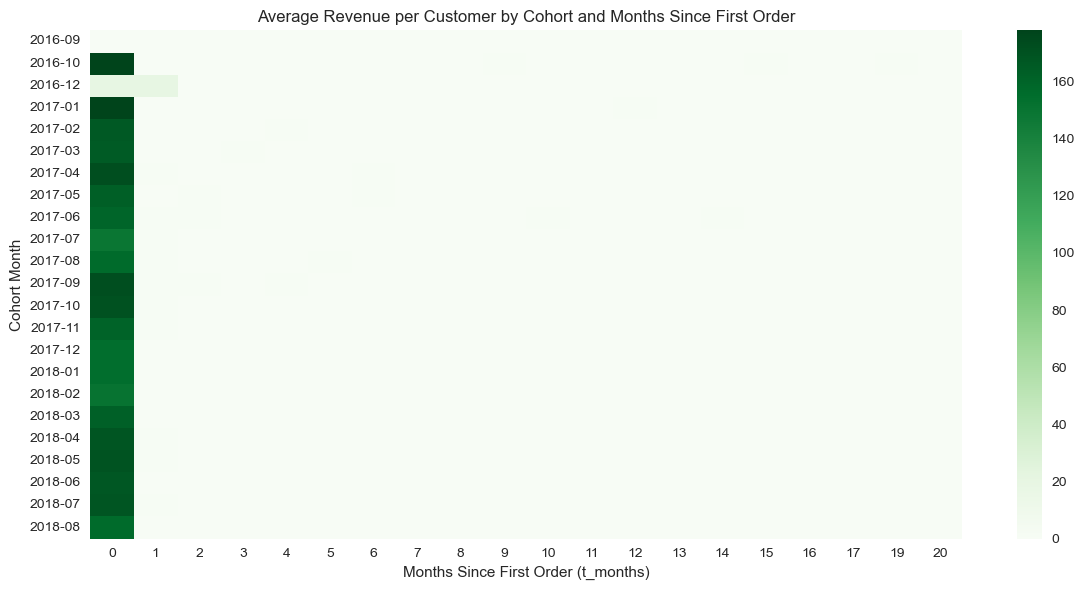

In [7]:
# Cohort revenue heatmap

plt.figure(figsize=(12, 6))                                                                                                      
sns.heatmap(cohort_pivot, cmap="Greens")                                                                                         
plt.title("Average Revenue per Customer by Cohort and Months Since First Order")                                                 
plt.xlabel("Months Since First Order (t_months)")                                                                                
plt.ylabel("Cohort Month")                                                                                                       
plt.tight_layout()                                                                                                               
plt.show()  

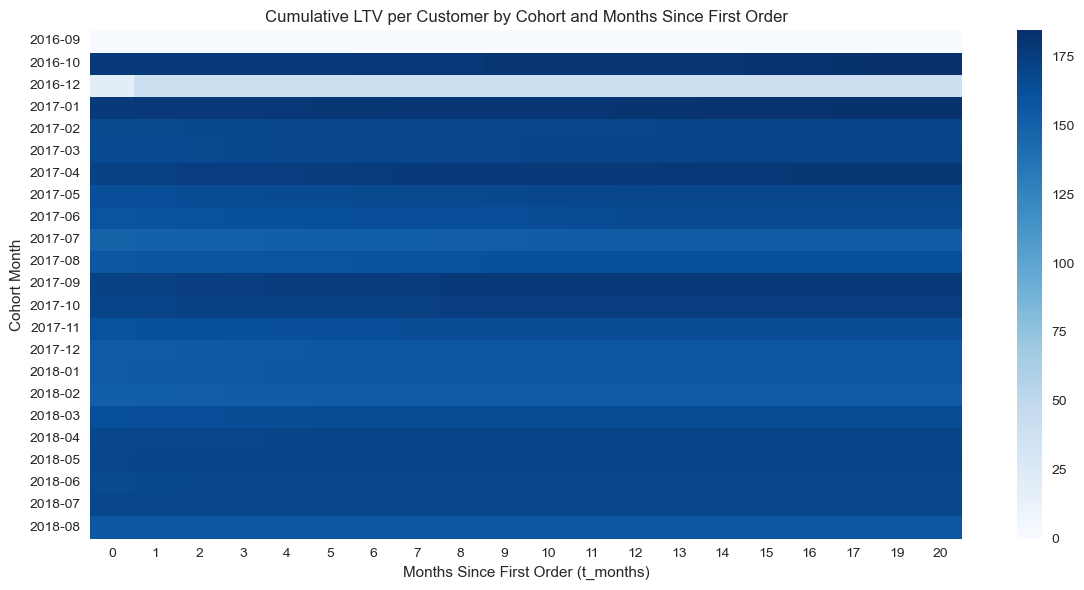

In [8]:
# Cumulative LTV heatmaps 

plt.figure(figsize=(12, 6))                                                                                                      
sns.heatmap(cohort_cum, cmap="Blues")                                                                                            
plt.title("Cumulative LTV per Customer by Cohort and Months Since First Order")                                                  
plt.xlabel("Months Since First Order (t_months)")                                                                                
plt.ylabel("Cohort Month")                                                                                                       
plt.tight_layout()                                                                                                               
plt.show()   

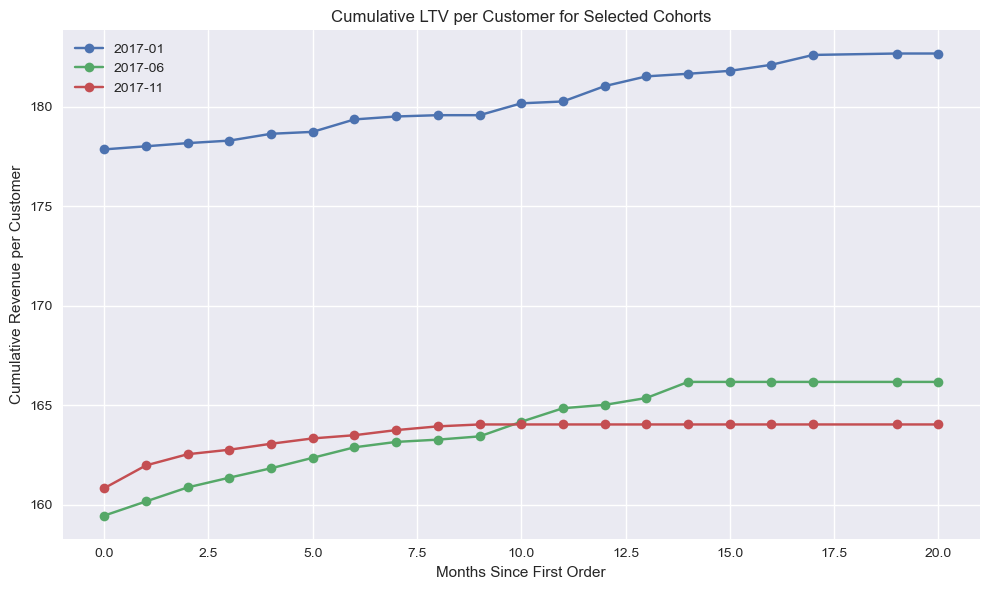

In [9]:
# Selected cohorts’ LTV curves 

plt.figure(figsize=(10, 6))                                                                                                      
                                                                                                                                  
selected_cohorts = ["2017-01", "2017-06", "2017-11"]                                                                             
for cohort in selected_cohorts:                                                                                                  
    mask = cohort_cum.index.astype(str) == cohort                                                                                
    if mask.any():                                                                                                               
        y = cohort_cum.loc[mask].values[0]                                                                                       
        x = cohort_cum.columns                                                                                                   
        plt.plot(x, y, marker="o", label=cohort)                                                                                 
                                                                                                                                  
plt.title("Cumulative LTV per Customer for Selected Cohorts")                                                                    
plt.xlabel("Months Since First Order")                                                                                           
plt.ylabel("Cumulative Revenue per Customer")                                                                                    
plt.legend()                                                                                                                     
plt.tight_layout()                                                                                                               
plt.show()  

## VII. Retention analysis

In [10]:
activity = (
    orders_df 
    .groupby(["customer_unique_id", "cohort_month", "t_months"])["order_id"] 
    .nunique() 
    .reset_index() 
) 
                                                                                                                                  
activity["active"] = (activity["order_id"] > 0).astype(int) 

retention = ( 
    activity  
    .groupby(["cohort_month", "t_months"])["active"] 
    .sum() 
    .reset_index() 
    .merge(cohort_sizes, on="cohort_month", how="left") 
) 

retention["retention_rate"] = retention["active"] / retention["cohort_size"] 

retention_pivot = retention.pivot( 
    index="cohort_month", 
    columns="t_months", 
    values="retention_rate", 
).fillna(0.0) 

retention_pivot.head() 


t_months,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort_month,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-10,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.003817,0.000000,0.000000,0.003817,0.000000,0.003817,0.000000,0.003817,0.000000,0.003817,0.000000,0.003817,0.007634,0.007634
2016-12,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01,1.0,0.002789,0.002789,0.001395,0.004184,0.001395,0.004184,0.001395,0.001395,0.000000,0.004184,0.001395,0.006974,0.004184,0.001395,0.001395,0.002789,0.004184,0.001395,0.000000
2017-02,1.0,0.001843,0.003071,0.001229,0.004300,0.001229,0.002457,0.001843,0.001229,0.001843,0.001229,0.003071,0.001229,0.001843,0.001229,0.000614,0.000614,0.001843,0.000000,0.000000


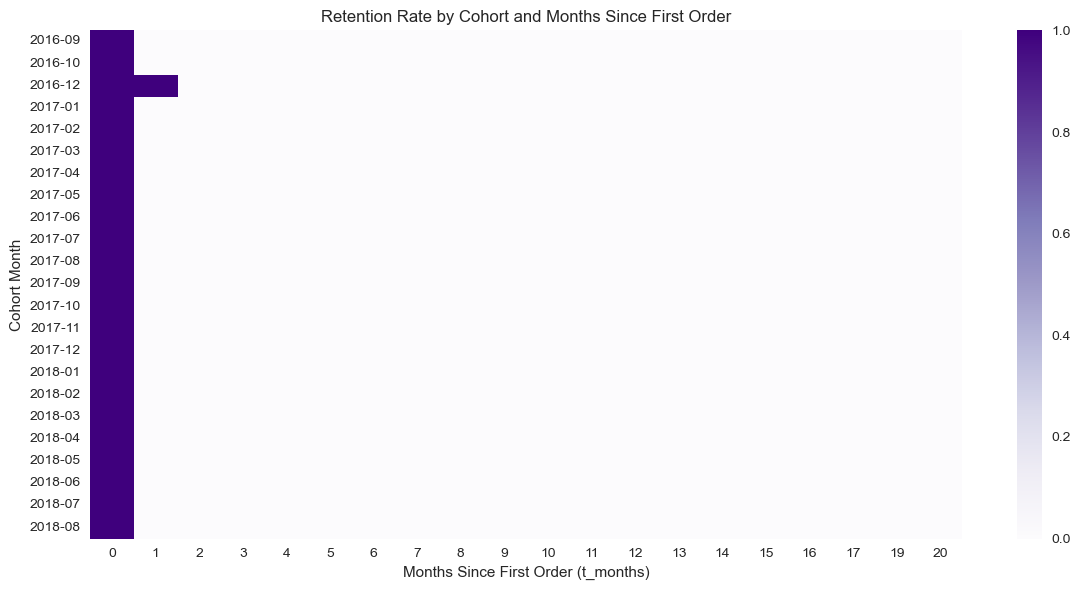

In [11]:
# Retention heatmap 

plt.figure(figsize=(12, 6)) 
sns.heatmap(retention_pivot, cmap="Purples", vmax=1.0) 
plt.title("Retention Rate by Cohort and Months Since First Order") 
plt.xlabel("Months Since First Order (t_months)") 
plt.ylabel("Cohort Month") 
plt.tight_layout() 
plt.show() 


## IX. Time‑based train/test split and baseline model 

### LTV$_{12m}$ label and early-behaviour features


In [12]:
# LTV_12m = sum of revenue in first 12 months (t_months 0..11)  
ltv_12m = (                                                                                                                      
    orders_df[orders_df["t_months"] <= 11]                                                                                       
    .groupby("customer_unique_id")["order_revenue"]                                                                              
    .sum()                                                                                                                       
    .rename("ltv_12m")                                                                                                           
)                                                                                                                                
                                                                                                                                  
# Early 1-month features (t_months 0 only)                                                                                       
early_1m = (                                                                                                                     
    orders_df[orders_df["t_months"] <= 0]                                                                                        
    .groupby("customer_unique_id")                                                                                               
    .agg(                                                                                                                        
        rev_1m=("order_revenue", "sum"),                                                                                         
        n_orders_1m=("order_id", "nunique")                                                                                      
    )                                                                                                                            
)  

# Early 3-month features (t_months 0..2)                                                                                         
early_3m = (                                                                                                                     
    orders_df[orders_df["t_months"] <= 2]                                                                                        
    .groupby("customer_unique_id")                                                                                               
    .agg(                                                                                                                        
        rev_3m=("order_revenue", "sum"),                                                                                         
        n_orders_3m=("order_id", "nunique")                                                                                      
    )                                                                                                                            
) 

# Merge into modeling dataframe                                                                                                
model_df = (                                                                                                                     
    customer_summary                                                                                                             
    .set_index("customer_unique_id")                                                                                             
    .join([ltv_12m, early_1m, early_3m])                                                                                         
    .fillna(0.0)                                                                                                                 
    .reset_index()                                                                                                               
) 

model_df["cohort_month_str"] = model_df["cohort_month"].astype(str)                                                              
model_df["ltv_12m"].describe() 

model_df.to_csv(f"{data_dir}/model_df.csv")

In [13]:
# time-based split: train on customers acquired up to 2017-12-31, test on later cohorts 
cutoff_date = pd.to_datetime("2017-12-31")   

train_mask = model_df["first_order_date"] <= cutoff_date  
test_mask = model_df["first_order_date"] > cutoff_date  

train_df = model_df[train_mask].copy()                                                                                           
test_df = model_df[test_mask].copy()                                                                                             
                                                                                                                                  
feature_cols = [                                                                                                                 
    "cohort_month_str",                                                                                                          
    "customer_state",                                                                                                            
    "rev_1m",                                                                                                                    
    "n_orders_1m",                                                                                                               
    "rev_3m",                                                                                                                    
    "n_orders_3m",                                                                                                               
]                                                                                                                                
target_col = "ltv_12m"                                                                                                           
                                                                                                                                  
X_train = train_df[feature_cols]                                                                                                 
y_train = train_df[target_col]                                                                                                   
                                                                                                                                  
X_test = test_df[feature_cols]                                                                                                   
y_test = test_df[target_col]                                                                                                     
                                                                                                                                  
len(X_train), len(X_test)  

(42325, 51033)

### Build pipeline and evaluate

In [14]:
cat_cols = ["cohort_month_str", "customer_state"]                                                                                
num_cols = ["rev_1m", "n_orders_1m", "rev_3m", "n_orders_3m"]                                                                    
                                                                                                                                  
preprocess = ColumnTransformer(                                                                                                  
    transformers=[                                                                                                               
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),                                                               
        ("num", "passthrough", num_cols),                                                                                        
    ]                                                                                                                            
)                                                                                                                                
                                                                                                                                  
model = GradientBoostingRegressor(random_state=42)                                                                               
                                                                                                                                  
pipe = Pipeline(                                                                                                                 
    steps=[                                                                                                                      
        ("preprocess", preprocess),                                                                                              
        ("model", model),                                                                                                        
    ]                                                                                                                            
)                                                                                                                                
                                                                                                                                  
def log1p_transform(y):   # calculates the natural logarithm of 1 + x for each element x in an input.                                                                                                        
    return np.log1p(y)                                                                                                           
                                                                                                                                  
def inv_log1p(y_log):                                                                                                            
    return np.expm1(y_log)                                                                                                       
                                                                                                                                  
y_train_log = log1p_transform(y_train)                                                                                           
y_test_log = log1p_transform(y_test)                                                                                             
                                                                                                                                  
pipe.fit(X_train, y_train_log)                                                                                                   
                                                                                                                                  
y_pred_log = pipe.predict(X_test)                                                                                                
y_pred = inv_log1p(y_pred_log)                                                                                                   
                                                                                                                                  
mae = mean_absolute_error(y_test, y_pred)                                                                                        
rmse = np.sqrt(mean_squared_error(y_test, y_pred))                                                                               
                                                                                                                                  
mae, rmse 

(3.0246406437805824, 14.545234560697065)

## X. Decile‑based evaluation and revenue capture

In [15]:
eval_df = pd.DataFrame(                                                                                                          
    {                                                                                                                            
        "y_true": y_test.values,                                                                                                 
        "y_pred": y_pred,                                                                                                        
    },                                                                                                                           
    index=y_test.index,                                                                                                          
).reset_index(drop=True)                                                                                                         
                                                                                                                                  
# true LTV deciles                                                                                                               
eval_df["true_decile"] = pd.qcut(                                                                                                
    eval_df["y_true"].rank(method="first"),                                                                                      
    10,                                                                                                                          
    labels=False,                                                                                                                
) + 1                                                                                                                            
                                                                                                                                  
decile_mae = (                                                                                                                   
    eval_df
    .groupby("true_decile")[["y_true", "y_pred"]] 
    .apply(lambda g: mean_absolute_error(g["y_true"], g["y_pred"])) 
)                                                                                                                                
                                                                                                                                  
print("MAE (overall):", round(mae, 2))                                                                                           
print("RMSE (overall):", round(rmse, 2))                                                                                         
print()                                                                                                                          
print("MAE by true LTV_12m decile:")                                                                                             
print(decile_mae)                                                                                                                
                                                                                                                                  
# revenue capture: what share of total revenue is in top 10% by predicted LTV                                                    
eval_df["pred_rank"] = eval_df["y_pred"].rank(ascending=False, method="first")                                                   
threshold = np.percentile(eval_df["pred_rank"], 10)                                                                              
                                                                                                                                  
top10 = eval_df[eval_df["pred_rank"] <= threshold]                                                                               
revenue_share_top10 = top10["y_true"].sum() / eval_df["y_true"].sum()   
                                                                                                                                  
print()                                                                                                                          
print("Share of total true LTV_12m in top 10% of customers by predicted LTV_12m:",                                               
      round(revenue_share_top10 * 100, 1), "%") 

MAE (overall): 3.02
RMSE (overall): 14.55

MAE by true LTV_12m decile:
true_decile
1      0.947800
2      1.131941
3      1.332362
4      1.404660
5      1.577404
6      2.114852
7      1.997927
8      2.885086
9      4.449119
10    12.404107
dtype: float64

Share of total true LTV_12m in top 10% of customers by predicted LTV_12m: 37.9 %


BUSINESS METRIC: revenue_share_top10 measures 'Revenue Recall'. If we only targeted the top 10% of predicted users, we would capture 37.9% of the total potential value. 

## XI. Marketplace segmentation: first category and geography

In [16]:
if order_items is not None and products is not None:                                                                             
    items_prod = order_items.merge(                                                                                              
        products[["product_id", "product_category_name"]],                                                                       
        on="product_id",                                                                                                         
        how="left",                                                                                                              
    )                                                                                                                            
                                                                                                                                  
    # first order per customer                                                                                                   
    first_orders_per_cust = (                                                                                                    
        orders_df                                                                                                                
        .sort_values("order_purchase_timestamp")                                                                                 
        .groupby("customer_unique_id", as_index=False)                                                                           
        .first()[["customer_unique_id", "order_id"]]                                                                             
    )                                                                                                                            
                                                                                                                                  
    first_items = first_orders_per_cust.merge(items_prod, on="order_id", how="left")                                             
                                                                                                                                  
    first_category = (                                                                                                           
        first_items                                                                                                              
        .groupby("customer_unique_id")["product_category_name"]                                                                  
        .first()                                                                                                                 
        .rename("first_category")                                                                                                
        .reset_index()                                                                                                           
    )                                                                                                                            
                                                                                                                                  
    model_df_seg = model_df.merge(first_category, on="customer_unique_id", how="left")                                           
                                                                                                                                  
    # LTV by first category (only categories with enough customers)                                                              
    cat_stats = (                                                                                                                
        model_df_seg                                                                                                             
        .groupby("first_category")["ltv_12m"]                                                                                    
        .agg(["count", "median", "mean"])                                                                                        
        .reset_index()                                                                                                           
        .sort_values("median", ascending=False)                                                                                  
    )                                                                                                                            
                                                                                                                                  
    cat_stats = cat_stats[cat_stats["count"] >= 100]                                                                             
                                                                                                                                  
    cat_stats.head(10)                                                                                                           
else:                                                                                                                            
    print("Order items / products tables not available; skipping category analysis.")                                            
                                                                                                                                  

### LTV₁₂ₘ by state                                                                                                     

In [17]:
                                                                                                                                
state_stats = (                                                                                                                  
    model_df                                                                                                                     
    .groupby("customer_state")["ltv_12m"]                                                                                        
    .agg(["count", "median", "mean"])                                                                                            
    .reset_index()                                                                                                               
    .sort_values("median", ascending=False)                                                                                      
)                                                                                                                                
                                                                                                                                  
state_stats.head(10)         

,customer_state,count,median,mean
0,AC,76,166.525,257.713816
20,RO,230,161.980,246.756957
14,PB,504,157.555,274.279345
16,PI,464,151.515,226.879677
21,RR,40,150.910,225.988000
3,AP,66,147.210,244.572879
13,PA,922,145.970,229.890727
26,TO,267,144.890,224.746704
19,RN,464,142.430,217.086853
1,AL,387,142.330,243.399974


### Visualize the top categories

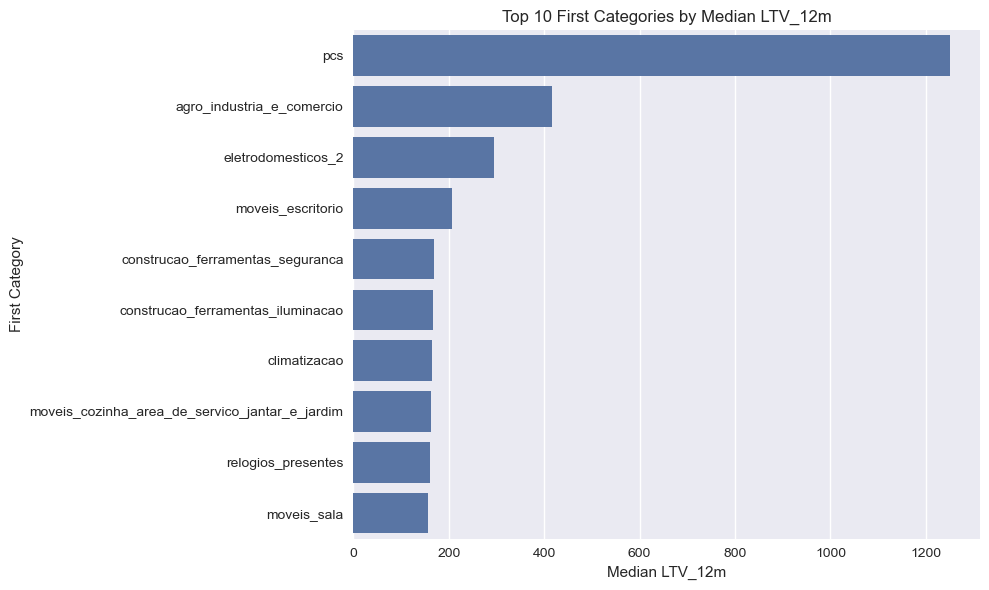

In [18]:
if order_items is not None and products is not None:                                                                             
    plt.figure(figsize=(10, 6))                                                                                                  
    top_cats = cat_stats.head(10)                                                                                                
    sns.barplot(data=top_cats, x="median", y="first_category")                                                                   
    plt.title("Top 10 First Categories by Median LTV_12m")                                                                       
    plt.xlabel("Median LTV_12m")                                                                                                 
    plt.ylabel("First Category")                                                                                                 
    plt.tight_layout()                                                                                                           
    plt.show()                                                                                                                   

### Visualize the top states

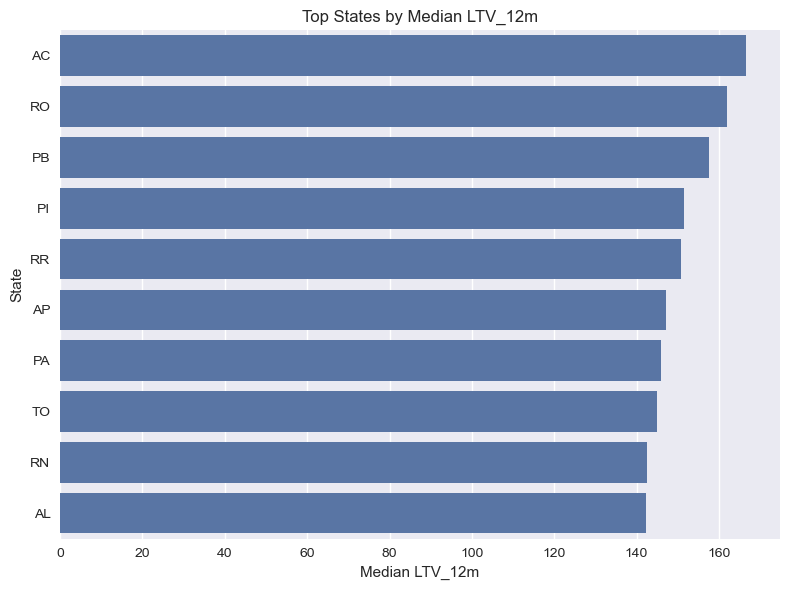

In [19]:
plt.figure(figsize=(8, 6))                                                                                                       
top_states = state_stats.head(10)                                                                                                
sns.barplot(data=top_states, x="median", y="customer_state")                                                                     
plt.title("Top States by Median LTV_12m")                                                                                        
plt.xlabel("Median LTV_12m")                                                                                                     
plt.ylabel("State")                                                                                                              
plt.tight_layout()                                                                                                               
plt.show()       


## XII. Interpretation and recommendations

Cohort revenue and LTV patterns                                                                                                   

 • Across cohorts, revenue per customer is strongly front‑loaded.                                                                 
    • Most cohorts realise the majority of their LTV within 6–12 months.                                                          
    • After ≈ 6–9 months, incremental gains are small, which is typical for e‑commerce and marketplaces.                          

Retention behaviour                                                                                                               

 • Retention drops sharply in the first few months after acquisition.                                                             
    • Many customers purchase once and do not return.                                                                             
    • A smaller base of repeat customers drives a disproportionate share of long‑run revenue.                                     

LTV₁₂ₘ distribution                                                                                                               

 • The LTV₁₂ₘ distribution is heavy‑tailed:                                                                                       
    • Median ≈ 108, mean ≈ 165, maximum > 13,600.                                                                                 
    • A small set of “whale” customers generate very high revenue compared to the median user.                                    

Model performance and business utility                                                                                            

 • On a realistic time‑based split (train on earlier cohorts, test on later ones), the baseline Gradient Boosting model using only
   cohort, state, and early‑behaviour features achieves:                                                                          
    • MAE on the order of a few currency units, which is roughly 3–4% of a typical customer’s LTV.                                
    • Higher RMSE driven by high‑LTV outliers, which is expected given the heavy tail.                                            
 • Decile‑based evaluation shows that:                                                                                            
    • Errors are small for the bulk of customers (middle deciles).                                                                
    • The largest errors occur in the highest true‑LTV decile, where exact prediction is intrinsically harder but directionally   
      the model can still identify many high‑value customers.                                                                     
 • Revenue capture analysis shows that:                                                                                           
    • The top 10% of customers ranked by predicted LTV₁₂ₘ account for a large fraction of realised revenue (you can insert the    
      exact percentage from the revenue_share_top10 output).                                                                      
    • This is practically useful for targeting high‑value users with tailored experiences and offers.                             

Marketplace‑specific segment insights                                                                                             

 • First category analysis suggests that customers who start in certain categories have significantly higher LTV₁₂ₘ than those    
   starting elsewhere.                                                                                                            
    • A marketplace can use this to design onboarding and recommendation flows that expose new users to high‑retention categories 
      and high‑quality sellers early.                                                                                             
 • Geographic analysis shows meaningful differences in LTV₁₂ₘ by state.                                                           
    • This informs regional marketing strategy and supply‑side planning (e.g. where to onboard more sellers).                     

Recommendations for a marketplace product team                                                                                    

 1 Focus on early‑life engagement                                                                                                 
    • Most value is realised within the first 6–12 months, and early behaviour is highly predictive of LTV₁₂ₘ.                    
    • Priorities:                                                                                                                 
       • Encourage second and third orders within the first 30–60 days (e.g. follow‑up emails, in‑app prompts, personalised       
         bundles).                                                                                                                
       • Test onboarding flows that direct new customers into categories and sellers associated with higher LTV.                  
 2 Allocate acquisition budget by expected cohort quality                                                                         
    • Not all cohorts and regions are equal in terms of LTV₁₂ₘ.                                                                   
    • Use predicted LTV₁₂ₘ to:                                                                                                    
       • Set CAC bids proportional to expected LTV instead of using a single average CAC.                                         
       • Shift budget towards channels and segments that bring higher‑value cohorts.                                              
 3 Integrate LTV predictions into CRM and experimentation                                                                         
    • Use predicted LTV₁₂ₘ early in the lifecycle to:                                                                             
       • Identify high‑potential customers and offer enhanced personalisation or loyalty perks.                                   
       • Avoid over‑spending on chronically low‑value segments.                                                                   
    • Design experiments such as:                                                                                                 
       • Targeting high‑predicted‑LTV customers with richer recommendations or loyalty incentives and measuring incremental       
         revenue and retention against a control group.  

## Next steps                                                                                                                        

• Save the trained pipeline with joblib and expose a minimal FastAPI endpoint as shown earlier.                                  
• Add a small unit test file (e.g. checking feature shapes and that t_months is non‑negative). 